# COVID-19 Number of Confirmed Cases Projections

## An Actuarial Modelling Approach

#### By [Alban Tranchard](www.linkedin.com/in/alban-tranchard-actuary) 

#### Explanation article can be found on Medium: [covid-19-cases-projections](https://medium.com/@alban.tranchard/covid-19-cases-projections-4d09fe655303?source=friends_link&sk=a9506c925ca80fbd51a95727c8b7a741) 

#### Introduction  

- The basic idea is to model the progression of the number of confirmed cases over time.

- Instead of using the calendar dates, we introduced a __development time__ dimension to remove the COVID-19 __"time lag"__ between the various countries.
- The origin Devt Time (devt_time= 0) corresponds to the first date when the number of confirmed cases has reached a minimum threshold per capita, for a given country-area. The threshold has been arbitrary chosen and set to 5 cases per mio per capita.
- Our model is relatively simple: `# Confirmed Cases (dvt time t+1) = Factor(t,t+1) * # Confirmed Cases (dvt time t)`.
- In actuarial speak, `Factor` is called a __link ratio__ (or development factor). This model approach is very similar to standard loss reserving models.
- The observed link ratios are defined by `# Confirmed Cases (dvt time t+1) / # Confirmed Cases (dvt time t)`. 
- The task is to model the `Factor(t,t+1)`, as a function of the development time for many countries.
- `Factor(t,t+1)` is always __>=1__. At ultimate, it equals 1 where there is no more progression.
- Therefore `Factor(t,t+1)` can be seen as `1+function(t,country)` where `function(t,country)` is what we want to model.
- After consideration, I have selected a __log-linear model__, i.e where `Log(function(t,country))` is linear.
- In addition, we use a *weighted regression model*, with `# Confirmed Cases (dvt time t)` being the weight. 

#### Required Libraries

In [1]:
import pandas as pd
import numpy as np

from patsy import dmatrix, DesignInfo # convenient library to create a model design matrix using a "formula style" specification. Nice!  

from sklearn.linear_model import LinearRegression # Using SciKit-Learn to compute our regression model
from sklearn.compose import TransformedTargetRegressor # we will model a log-linear model (i.e. linear in the log space)

from scipy.stats.distributions import  t # we will use this to compute confidence interval

import statsmodels.api as sm # not really needed but can check our weighted standard errors & confidence interval are similar
import statsmodels.stats as stats

import plotly_express as px # Awesome charting library from our friends at Plotly in Canada!

import ipywidgets as widgets # Adding some interactivity to this notebook

In [2]:
pd.set_option('display.max_rows', None) # if we want to print the whole dataframe

#### Getting the Data

__NOTE__: The csv file is updated daily so the `regression model` will change & update based on newest data 

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/chk2817/covid-19-curves/master/data/covid.csv',encoding='utf-8')

- The data file is updated daily for the following [COVID-19 Dash App](https://covid19-curves.herokuapp.com/)
- The corresponding [Git repo](https://github.com/chk2817/covid-19-curves) 
- The raw data is sourced from the [John Hopkins Git](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports) repo.
- Population statistics split by country were sourced from the [UN 2020 estimates](https://population.un.org/wpp/Download/Standard/Population/). Additional population % split by State / Provinces was sourced from Wikipedia.



In [4]:
# need to cast the date filed as datetime type
df["date"] = pd.to_datetime(df["date"],dayfirst=True)

In [5]:
df.columns

Index(['region', 'subregion', 'country', 'area', 'country_area', 'date',
       'confirmed_cases', 'deaths', 'recovered', 'population', 'lat', 'long',
       'lat_long_flag', 'pop_flag', 'active', 'confirmed_cases_rate',
       'deaths_rate', 'recovered_rate', 'active_rate', 'C_xs_T', 'devt_time'],
      dtype='object')

- the country_area field in cases is equal to country except for China, United States, Canada & Australia where we split further down to State / Provinces

- Not all the data is needed for the analysis.

- Region, Sub-region, and country are set as per the UN classification. It is not a political split but a geo split, which is what we want

- The development time "devt_time" is already computed

#### Data Preparation

In [6]:
# Select the relevant Dataset
dff=df.loc[(df['devt_time']>=0),['region','subregion','country','country_area','confirmed_cases','population','date','devt_time',]].copy(deep=True)
# sort dataframe
dff.sort_values(['country_area','devt_time'],inplace=True)
# We will 'extend' the dataframe to contain the prediction up until a certain date, eg, say July 1st
# adding field data = 'Observed', this data field will be set to 'Estimate' for the predicted values to easily distinguish them
dff['data']='Observed'

In [7]:
# Data not included in the model analysis as they have not reached devt_time=0 (i.e. 5 per mio capita rate)
df.loc[df['devt_time']==-99].groupby('country_area')['confirmed_cases'].max()

country_area
American Samoa                  0
Angola                         25
Australia - Other               0
Benin                          54
Burma                         139
Burundi                        11
Canada - Other                  0
Central African Republic       16
Chad                           33
China - Guizhou               147
China - Hebei                 328
China - Jilin                 108
China - Liaoning              146
China - Qinghai                18
China - Tibet                   1
China - Xinjiang               76
China - Yunnan                184
Dem Republic Congo            377
Ethiopia                      116
Gambia                         10
Laos                           19
Madagascar                    121
Malawi                         33
Mauritania                      7
Mozambique                     46
Nepal                          48
Nicaragua                      11
Nigeria                       981
Papua New Guinea                8
S

In [8]:
# getting the most recent records split by country_area
grpby_dff=dff.groupby(['country_area']).max()
# we will project up until July 1st
final_date=np.datetime64('2020-07-01')

# we create the additional records for the model prediction
# There might be a more "classy" way of doing this 
for index, row in grpby_dff.iterrows():
    rpt=(final_date-row['date'])/ np.timedelta64(1, 'D')
    cty=np.repeat(index,rpt)
    region=np.repeat(row['region'],rpt)
    subregion=np.repeat(row['subregion'],rpt)
    country=np.repeat(row['country'],rpt)
    pop=np.repeat(row['population'],rpt)
    dte=np.arange(row['date']+np.timedelta64(1, 'D'),final_date++np.timedelta64(1, 'D'), dtype='datetime64[D]')
    dev=np.arange(row['devt_time']+1,row['devt_time']+rpt+1)
    data=np.repeat('Estimate',rpt)
    d=pd.DataFrame({'country_area': cty, 'population':pop,'date':dte,'devt_time':dev,'data':data, 
                    'subregion':subregion, 'region':region, 'country': country})
    dff=dff.append(d, ignore_index=True)

In [9]:
# Feature Engineering:
# our selected model as a first linear development up until devt_time 30 - expert judgement choice :=)
# Then we use another linear tail factor. 
# We also add the weights and link_ratio data
cut_off=30
dff['time_1']=dff['devt_time'].clip(upper=cut_off)
dff['time_2']=dff['devt_time'].apply(lambda x: np.maximum(0,x-cut_off))
dff['weight']=dff.groupby(['country_area'])['confirmed_cases'].shift(periods=1,fill_value=0)
dff['link_ratio']=dff.apply(lambda row: row['confirmed_cases']/row['weight'] if row['weight']>0 else None, axis=1)

#### Some EDA

In [10]:
country_list=dff['country_area'].unique().tolist()
plot_data_EDA=dff[dff['link_ratio']>1].copy(deep=True)
plot_data_EDA['log of factor']=np.log(plot_data_EDA['link_ratio']-1)

dd_country=widgets.Dropdown(options=country_list)
output_country=widgets.Output()

def dd_country_eventhandler(change):
    output_country.clear_output()
    data=plot_data_EDA[plot_data_EDA['country_area']==change.new]
    fig=px.scatter(data, x='devt_time',y='log of factor', trendline='ols', title=change.new, 
                   template='plotly_white',  opacity=0.5,color='country_area',
                   color_discrete_sequence=px.colors.qualitative.D3) #size='weight',
    fig.update_layout(showlegend=False)
    fig.data[1].line={'dash':'dot', 'color':'grey'}
    with output_country:
        display(fig)

dd_country.observe(dd_country_eventhandler, names='value')
display(dd_country)

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentin…

In [11]:
display(output_country)

Output()

In the plot above, we display the log of the observed development factors, i.e. log(cumulative_cases(t+1)/cumulative_cases(t)-1)

- The dash line is a simple linear trend (not weighted).
- The size of the observations is proportional to the weight, i.e. the previous cumulative_cases(t).
- By using a weighted regression, we will put more emphasis on the the "distribution" tail
- The weight also "favor" observations where we have more "exposure" with less emphasis on "outlier" observations. 

#### Define Preliminary Country Groups

In the model, we want to use a linear regresssion that is a function of the development time (decreasing function towards 0)  
and also a function of the country / area as countries do not necessarily follow the same development curves.  

However, for many countries, the `Link Ratio` observations may lack statistical robustness with a relatively small number of cases.  

To provide a more *parsimonious* model, we may need to define group of countries. 

I do not have a statistical rule to do this and often it is an iterative trial & error approach.  

In [12]:
# One idea is to keep the individual countries-area that have a sizeable number of cases / day
# and a reasonable number of observed development time days
grpby_dff['avg_cases']=grpby_dff['confirmed_cases']/(grpby_dff['devt_time']+1) # +1 because devt_time is 0-indexed

grpby_dff['country_grp']=grpby_dff.index.where((grpby_dff['avg_cases']>50) & (grpby_dff['devt_time']>10),'Others')

# Instead of encoding all other countries in one "other" bucket, we refine a bit  
grpby_dff.loc[(grpby_dff['country_grp']=='Others') & (grpby_dff['country']=='United States'),'country_grp']='RoUS'
grpby_dff.loc[(grpby_dff['country_grp']=='Others') & (grpby_dff['country']=='China'),'country_grp']='RoChina'
grpby_dff.loc[(grpby_dff['country_grp']=='Others') & (grpby_dff['region']=='Europe'),'country_grp']='RoEurope'
grpby_dff.loc[(grpby_dff['country']=='Canada'),'country_grp']='Canada'

In [13]:
grpby_dff.sort_values(['avg_cases'], ascending=False).head(20)

region         subregion  \
country_area                                                             
US - New York                       Northern America  Northern America   
Spain                                         Europe   Southern Europe   
Italy                                         Europe   Southern Europe   
UK                                            Europe   Northern Europe   
Germany                                       Europe    Western Europe   
Turkey              Northern Africa And Western Asia      Western Asia   
US - New Jersey                     Northern America  Northern America   
France                                        Europe    Western Europe   
Russia                                        Europe    Eastern Europe   
India                      Central And Southern Asia     Southern Asia   
Iran                       Central And Southern Asia     Southern Asia   
Brazil               Latin America And The Caribbean     South America   
US - Massachusetts                  Northern America  Northern America   
US - Pennsylvania                   Northern America  Northern America   
US - California                     Northern America  Northern America   
US - Michigan                       Northern America  Northern America   
US - Illinois                       Northern America  Northern America   
Belgium                                       Europe    Western Europe   
US - Florida                        Northern America  Northern America   
China - Hubei         Eastern And South-Eastern Asia      Eastern Asia   

                           country  confirmed_cases   population       date  \
country_area                                                                  
US - New York        United States           263460    19.613675 2020-04-23   
Spain                        Spain           213024    46.754783 2020-04-23   
Italy                        Italy           190483    60.496575 2020-04-23   
UK                  United Kingdom           138078    67.886004 2020-04-23   
Germany                    Germany           153129    83.783945 2020-04-23   
Turkey                      Turkey           101790    84.339067 2020-04-23   
US - New Jersey      United States           100025     8.955296 2020-04-23   
France                      France           120804    65.273512 2020-04-23   
Russia                      Russia            62773   145.934460 2020-04-23   
India                        India            23077  1380.004385 2020-04-23   
Iran                          Iran            87026    83.992953 2020-04-23   
Brazil                      Brazil            50036   212.559409 2020-04-23   
US - Massachusetts   United States            46023     7.006701 2020-04-23   
US - Pennsylvania    United States            38379    12.907357 2020-04-23   
US - California      United States            39561    39.837431 2020-04-23   
US - Michigan        United States            35296    10.069055 2020-04-23   
US - Illinois        United States            36937    12.776117 2020-04-23   
Belgium                    Belgium            42797    11.589616 2020-04-23   
US - Florida         United States            29648    21.654511 2020-04-23   
China - Hubei                China            68128    61.211190 2020-04-23   

                    devt_time      data    avg_cases         country_grp  
country_area                                                              
US - New York              46  Observed  5605.531915       US - New York  
Spain                      49  Observed  4260.480000               Spain  
Italy                      58  Observed  3228.525424               Italy  
UK                         44  Observed  3068.400000                  UK  
Germany                    49  Observed  3062.580000             Germany  
Turkey                     33  Observed  2993.823529              Turkey  
US - New Jersey            40  Observed  2439.634146     US - New Jersey  
Fra

In [14]:
# mapping is a Series with index country_area and values country_grp
# we use it to encode the dff dataset
mapping=grpby_dff['country_grp']
dff['country_grp']=dff['country_area'].map(mapping)

In [15]:
# For the tail factor where we have less observations, we only consider two groups of countries, 
# China and South Korea have shown a more rapid flattening of the curve compared to Europe / Rest of the World
grpby_dff['tail_grp']=grpby_dff['country']
grpby_dff.loc[grpby_dff['country'].isin(['China','South Korea']),'tail_grp']='tail grp 01'
grpby_dff.loc[~grpby_dff['country'].isin(['China','South Korea']),'tail_grp']='tail grp 02'
grpby_dff.loc[grpby_dff['country'].isin(['China','South Korea'])]

region     subregion  \
country_area                                                           
China - Anhui           Eastern And South-Eastern Asia  Eastern Asia   
China - Beijing         Eastern And South-Eastern Asia  Eastern Asia   
China - Chongqing       Eastern And South-Eastern Asia  Eastern Asia   
China - Fujian          Eastern And South-Eastern Asia  Eastern Asia   
China - Gansu           Eastern And South-Eastern Asia  Eastern Asia   
China - Guangdong       Eastern And South-Eastern Asia  Eastern Asia   
China - Guangxi         Eastern And South-Eastern Asia  Eastern Asia   
China - Hainan          Eastern And South-Eastern Asia  Eastern Asia   
China - Heilongjiang    Eastern And South-Eastern Asia  Eastern Asia   
China - Henan           Eastern And South-Eastern Asia  Eastern Asia   
China - Hubei           Eastern And South-Eastern Asia  Eastern Asia   
China - Hunan           Eastern And South-Eastern Asia  Eastern Asia   
China - Inner Mongolia  Eastern And South-Eastern Asia  Eastern Asia   
China - Jiangsu         Eastern And South-Eastern Asia  Eastern Asia   
China - Jiangxi         Eastern And South-Eastern Asia  Eastern Asia   
China - Ningxia         Eastern And South-Eastern Asia  Eastern Asia   
China - Shaanxi         Eastern And South-Eastern Asia  Eastern Asia   
China - Shandong        Eastern And South-Eastern Asia  Eastern Asia   
China - Shanghai        Eastern And South-Eastern Asia  Eastern Asia   
China - Shanxi          Eastern And South-Eastern Asia  Eastern Asia   
China - Sichuan         Eastern And South-Eastern Asia  Eastern Asia   
China - Tianjin         Eastern And South-Eastern Asia  Eastern Asia   
China - Zhejiang        Eastern And South-Eastern Asia  Eastern Asia   
South Korea             Eastern And South-Eastern Asia  Eastern Asia   

                            country  confirmed_cases  population       date  \
country_area                                                                  
China - Anhui                 China              991   64.872245 2020-04-23   
China - Beijing               China              593   22.516010 2020-04-23   
China - Chongqing             China              579   31.891631 2020-04-23   
China - Fujian                China              355   40.562007 2020-04-23   
China - Gansu                 China              139   27.234935 2020-04-23   
China - Guangdong             China             1585  115.836628 2020-04-23   
China - Guangxi               China              254   50.663616 2020-04-23   
China - Hainan                China              168    9.510447 2020-04-23   
China - Heilongjiang          China              928   39.296713 2020-04-23   
China - Henan                 China             1276   99.138896 2020-04-23   
China - Hubei                 China            68128   61.211190 2020-04-23   
China - Hunan                 China             1019   71.146859 2020-04-23   
China - Inner Mongolia        China              194   26.228922 2020-04-23   
China - Jiangsu               China              653   83.270865 2020-04-23   
China - Jiangxi               China              937   47.935974 2020-04-23   
China - Ningxia               China               75    7.073201 2020-04-23   
China - Shaanxi               China              279   39.773791 2020-04-23   
China - Shandong              China              787  103.774850 2020-04-23   
China - Shanghai              China              641   25.077712 2020-04-23   
China - Shanxi                China              197   38.186988 2020-04-23   
China - Sichuan               China              561   86.102219 2020-04-23   
China - Tianjin               China              189   16.148055 2020-04-23   
China - Zhejiang              China             1268   58.670231 2020-04-23   
South Korea             South Korea            10708   51.269183 2020-04-23   

                        devt_time      data   avg_cases    country_grp  \
country_area                                  

In [16]:
mapping=grpby_dff['tail_grp']
dff['tail_grp']=dff['country_area'].map(mapping)

In [17]:
dff.columns

Index(['region', 'subregion', 'country', 'country_area', 'confirmed_cases',
       'population', 'date', 'devt_time', 'data', 'time_1', 'time_2', 'weight',
       'link_ratio', 'country_grp', 'tail_grp'],
      dtype='object')

#### Building the first Regression Model

To fit a model, we need to have a design matrix X and the response variable y

- We have the time_1 and time_2 numerical features, which we will standardize (centered and scaled)
- the country_grp is a categorical feature

We use the the excellent library __patsy__ to help with the Design Matrix creation. It is relatively easy as patsy does all the hard work here

Our model is the following:  

- $Log\left ( development factor_{t}-1 \right )=\left (\alpha _{country\: grp}+\beta _{country\: grp}*t_1  \right )+ tail _{country\: grp}* t_2$

A linear decay for the first 30 development days (time t1) for each country group. Each country group has its own `alpha` and `beta`.  

A tail factor decay after 30 development days (time t2) for each tail country group.

In [18]:
# The desing matric is built on the whole dataset, i.e for both the observations and the estimate / predictions
# The model is fitted only to the observed data but dm will be used to run the model to get the estimates
dm=dmatrix('-1+country_grp + country_grp:standardize(time_1) + tail_grp:standardize(time_2)',dff, return_type='dataframe')

In [19]:
dm.columns

Index(['country_grp[Afghanistan]', 'country_grp[Algeria]',
       'country_grp[Argentina]', 'country_grp[Australia - NSW]',
       'country_grp[Austria]', 'country_grp[Belarus]', 'country_grp[Belgium]',
       'country_grp[Brazil]', 'country_grp[Cameroon]', 'country_grp[Canada]',
       ...
       'country_grp[US - Texas]:standardize(time_1)',
       'country_grp[US - Utah]:standardize(time_1)',
       'country_grp[US - Virginia]:standardize(time_1)',
       'country_grp[US - Washington]:standardize(time_1)',
       'country_grp[US - Wisconsin]:standardize(time_1)',
       'country_grp[Ukraine]:standardize(time_1)',
       'country_grp[United Arab Emirates]:standardize(time_1)',
       'country_grp[Uzbekistan]:standardize(time_1)',
       'tail_grp[tail grp 01]:standardize(time_2)',
       'tail_grp[tail grp 02]:standardize(time_2)'],
      dtype='object', length=212)

In [20]:
dm.shape

(30415, 212)

In [21]:
# want to capture the design matrix encoding information in the dm_di dataframe
# This will be useful when we want to plot the parameters for a given factor
di=dm.design_info

# column_names are all encoded factors / terms 
dm_di=pd.DataFrame({'col_name':di.column_names})

# for each factor / terms, we encode the corresponding factors
factors=[None]*len(di.column_names)
for elt in di.term_names:
    slice_=di.term_name_slices[elt]
    factors[slice_]=[elt]*len(factors[slice_])

dm_di['factors']=factors

#We also capture the corresponding term levels
#getting pretty factor levels, experimental
# useful for "pretty" plotting factor model parameters

dm_di['levels']=dm_di['col_name'].str.findall(r'\((.*)\)|\[(.*)\]')
dm_di['levels']=dm_di['levels'].apply(lambda x: str(x))
pattern = '|'.join(['\[', '\]', '\(','\)',"'",'T\.',','])
dm_di['levels']=dm_di['levels'].str.replace(pattern, '').str.strip()

In [22]:
dm_di.head()

col_name      factors           levels
0      country_grp[Afghanistan]  country_grp      Afghanistan
1          country_grp[Algeria]  country_grp          Algeria
2        country_grp[Argentina]  country_grp        Argentina
3  country_grp[Australia - NSW]  country_grp  Australia - NSW
4          country_grp[Austria]  country_grp          Austria

In [23]:
# as we do a weighted regression, I want to capture the weights for each of the factors-terms in the model
dm_obs=dm.loc[(dff['data']=='Observed') & (dff['devt_time']>0) & (dff['link_ratio']>1)]
dm_obs_ind=dm_obs.where(dm == 0, other=1) # Indicator matrix with 1 where dm[i,j]>0, 0 otherwise 
wgt_obs=dff[(dff['data']=='Observed') & (dff['devt_time']>0)& (dff['link_ratio']>1)]['weight'] # weight vector from the observed data 
wgt_obs=wgt_obs/wgt_obs.sum() # % weights
dm_weight=dm_obs_ind.T @ wgt_obs # matrix multiplacation to sum up all weights for each factor - terms
dm_weight=dm_weight.rename('factor_weight') # need to name the pd.Series before merging with dm_di dataframe
dm_di=dm_di.merge(dm_weight,how='left',left_on='col_name', right_index=True)

In [24]:
dm_di.head()

col_name      factors           levels  factor_weight
0      country_grp[Afghanistan]  country_grp      Afghanistan       0.000305
1          country_grp[Algeria]  country_grp          Algeria       0.000994
2        country_grp[Argentina]  country_grp        Argentina       0.001017
3  country_grp[Australia - NSW]  country_grp  Australia - NSW       0.001216
4          country_grp[Austria]  country_grp          Austria       0.008295

In [25]:
# Building the design matrix of observations only

X=dm.loc[(dff['data']=='Observed') & (dff['devt_time']>0) & (dff['link_ratio']>1)] # X is the design matrix of the observed data only
y=(dff[(dff['data']=='Observed') & (dff['devt_time']>0)& (dff['link_ratio']>1)]['link_ratio']-1) #target variable
wgt=dff[(dff['data']=='Observed') & (dff['devt_time']>0)& (dff['link_ratio']>1)]['weight'] # weight vector

In [26]:
X.shape

(7902, 212)

In [27]:
# Normally you would need to split the dataset into a train and test datasets 
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Fitting First Model

In [28]:
# we do the log transformation using the TransformedTargetRegressor
# fit_intercept term below should not really matter as we built X outside
tt = TransformedTargetRegressor(regressor=LinearRegression(fit_intercept=False),func=np.log, inverse_func=np.exp)
tt.fit(X, y, wgt)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
              inverse_func=<ufunc 'exp'>,
              regressor=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False),
              transformer=None)

In [29]:
 # Next to each factor / levels, we will capture the model estimate as well as build the weight std error and 95% confidence interval
dm_di['coef']=tt.regressor_.coef_
dm_di.head()

col_name      factors           levels  factor_weight  \
0      country_grp[Afghanistan]  country_grp      Afghanistan       0.000305   
1          country_grp[Algeria]  country_grp          Algeria       0.000994   
2        country_grp[Argentina]  country_grp        Argentina       0.001017   
3  country_grp[Australia - NSW]  country_grp  Australia - NSW       0.001216   
4          country_grp[Austria]  country_grp          Austria       0.008295   

       coef  
0 -4.948832  
1 -5.285371  
2 -5.152374  
3 -5.572962  
4 -5.295758

In [30]:
# Dataframe pred to contain the individual observations along with fitted values, weight, residuals etc...
pred=dff.loc[(dff['data']=='Observed') & (dff['devt_time']>0) & (dff['link_ratio']>1),['country_area','country_grp','devt_time','weight','link_ratio']]
pred['y']=np.log(pred['link_ratio']-1)
pred['y_hat'] = np.log(tt.predict(X))
pred['residuals']=pred['y']-pred['y_hat']

In [31]:
#SciKit learn does not compute the parameters std errors & thus confidence intervals. Statmodels does though. So we need to do it
# the commented code below is a fix to add a small number on the diagonal matrix when the matrix is singular and cannot be invested.
# Can happen depending on the model specification -  i.e. a full model with no country grouping had this problem
residuals=pred['residuals'].to_numpy()
W=np.diag(pred['weight'].to_numpy())
residuals=residuals[np.newaxis]
w_rss = residuals @ W @ residuals.T
w_sigma_squared_hat = w_rss[0, 0] / (X.shape[0] - X.shape[1])
#m=10^-8
sq_m=X.to_numpy().T @ W @ X.to_numpy()
#sq_m=sq_m+np.eye(sq_m.shape[0])*m
w_var_beta_hat = np.linalg.inv(sq_m) * w_sigma_squared_hat
w_stderr=np.sqrt(np.diag(w_var_beta_hat))

In [32]:
# Tval statistics is needed to compute the confidence interval
alpha=0.05 # 0.05 corresponds to a 95% CI interval while 0.1 would be for a 90% CI etc...
tval = t.ppf(1.0-alpha/2., X.shape[0]-X.shape[1])
tval

1.9602725200808147

In [33]:
# Adding the weighted std error, and 95% CI for the model parameters
dm_di['w_stderr']=w_stderr
dm_di['ci_95_upper']=tt.regressor_.coef_+w_stderr*tval
dm_di['ci_95_lower']=tt.regressor_.coef_-w_stderr*tval
dm_di.head()

col_name      factors           levels  factor_weight  \
0      country_grp[Afghanistan]  country_grp      Afghanistan       0.000305   
1          country_grp[Algeria]  country_grp          Algeria       0.000994   
2        country_grp[Argentina]  country_grp        Argentina       0.001017   
3  country_grp[Australia - NSW]  country_grp  Australia - NSW       0.001216   
4          country_grp[Austria]  country_grp          Austria       0.008295   

       coef  w_stderr  ci_95_upper  ci_95_lower  
0 -4.948832  0.921569    -3.142306    -6.755358  
1 -5.285371  0.279682    -4.737117    -5.833625  
2 -5.152374  0.259136    -4.644397    -5.660351  
3 -5.572962  0.214831    -5.151835    -5.994089  
4 -5.295758  0.095515    -5.108524    -5.482993

In [34]:
# how many country levels do we have?
len(dm_di.loc[dm_di['factors']=='country_grp','levels'].unique())

105

In [35]:
factors_list_2=dm_di['factors'].unique().tolist()
dd_factors_2=widgets.Dropdown(options=factors_list_2)
output_factors_2=widgets.Output()

def dd_factors_2_eventhandler(change):
    output_factors_2.clear_output()
    plot_data=dm_di.loc[(dm_di['factors']==change.new)] 
    fig=px.line(plot_data,x='levels',y='coef',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.add_bar(x=plot_data['levels'],y=plot_data['factor_weight'], name='weight', yaxis='y2', opacity=0.75, marker_color='lightgrey')
    fig.add_scatter(x=plot_data['levels'],y=plot_data['ci_95_upper'],line_dash='dash', name='CI Upper', marker_color=px.colors.qualitative.D3[1])
    fig.add_scatter(x=plot_data['levels'],y=plot_data['ci_95_lower'],line_dash='dash', name='CI Lower', marker_color=px.colors.qualitative.D3[1])
    fig.update_layout(yaxis2=dict(title="weight",anchor="x",overlaying="y",side="right", showgrid=False))
    
    with output_factors_2:
        display(fig)

dd_factors_2.observe(dd_factors_2_eventhandler, names='value')
display(dd_factors_2)

Dropdown(options=('country_grp', 'country_grp:standardize(time_1)', 'tail_grp:standardize(time_2)'), value='co…

In [36]:
display(output_factors_2)

Output()

In [37]:
# for some reason I could not get the right R-Squared from Scikit score function.
# the math code below can be used to compute the model together with the R-Squqred stats
# Below the full linear regression math only using numpy 
# not all is needed to get to the R-squared values, code streamlined below in the second model iteration
beta_hat = np.linalg.inv(X.to_numpy().T @ np.diag(wgt) @ X.to_numpy() ) @ X.to_numpy().T @ np.diag(wgt) @ np.log(y.values)
y_arr=np.log(y.to_numpy())
y_arr_hat=X.to_numpy() @ beta_hat
y_m=y_arr.T@wgt.to_numpy()/wgt.sum()
ss_tot=(y_arr-y_m)@ np.diag(wgt)  @ (y_arr-y_m).T
res=y_arr-y_arr_hat
ss_res=(res @ np.diag(wgt) @ res.T)
r2=1-ss_res/ss_tot
r2_adj=1-(ss_res/ss_tot)*((X.shape[0]-1)/(X.shape[0]-X.shape[1]-1))
sigma2_hat = (res @ np.diag(wgt) @ res.T)/(X.shape[0]-X.shape[1])
var_hat=np.linalg.inv(X.to_numpy().T @ np.diag(wgt) @ X.to_numpy()) * sigma2_hat
stderr_hat=np.sqrt(np.diag(var_hat))

In [38]:
r2_adj

0.7715198236370124

#### Using Stat Models to check our wiegthed standard errors caclulations

In [39]:
# checking our math does match with statmodel wls model, it does. Good!
mod_wls = sm.WLS(np.log(y), X, weights=wgt)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:             link_ratio   R-squared:                       0.778
Model:                            WLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     127.5
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:08:24   Log-Likelihood:                -16560.
No. Observations:                7902   AIC:                         3.354e+04
Df Residuals:                    7690   BIC:                         3.502e+04
Df Model:                         211                                         
Covariance Type:            nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [40]:
# inserting the fitted values together with the predictions for the days to come from this first model
dff['link_ratio_predicted']=1+tt.predict(dm)

In [41]:
country_list_4=dff['country_area'].unique().tolist()
dd_country_4=widgets.Dropdown(options=country_list_4)
output_country_4=widgets.Output()

def dd_country_4_eventhandler(change):
    output_country_4.clear_output()
    plot_data=dff.loc[(dff['country_area']==change.new) & (dff['devt_time']>0)]
    fig=px.line(plot_data,x='devt_time',y='link_ratio',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.add_scatter(x=plot_data['devt_time'],y=plot_data['link_ratio_predicted'],line_dash='dash', marker_color=px.colors.qualitative.D3[1])  
    fig.update_layout(yaxis_title='Link Ratio / Daily Development Factor ', showlegend=False)
    with output_country_4:
        display(fig)

dd_country_4.observe(dd_country_4_eventhandler, names='value')
display(dd_country_4)

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentin…

In [42]:
# plotting the confirmed cases daily development factors.
# the red dotted line is the model fit
# the fit is generally getting better in the tail which is what matters most for the outward predictions.
display(output_country_4)

Output()

#### Initial Model Predictions

In [43]:
# This is the code to estimates the cumulative number of confirmed cases up until July 1st
# Take the latest number of confirmed cases (today) * link_ratio(today to tomorrow) * link(tomorrow to day after) etc... to get to the ultimate number of confirmed cases
dff['lr_cumul']=dff.loc[dff['data']=='Estimate'].groupby(['country_area'])['link_ratio_predicted'].cumprod()
dff['pred_cases']=dff['lr_cumul']*dff.groupby(['country_area'])['confirmed_cases'].transform('max')
dff['all_cases']=dff['confirmed_cases'].fillna(0)+dff['pred_cases'].fillna(0)
dff['all_cases_inc']=dff.groupby(['country_area'])['all_cases'].diff()
# by taking the diff(), the first entry is NaN so we can to this to get the first entry
dff.loc[dff['all_cases_inc'].isnull(),'all_cases_inc']=dff.loc[dff['all_cases_inc'].isnull(),'all_cases']

In [44]:
country_list_5=dff['country'].unique().tolist()
dd_country_5=widgets.Dropdown(options=country_list_5)
output_country_5=widgets.Output()

def dd_country_5_eventhandler(change):
    output_country_5.clear_output()
    plot_data=dff.loc[dff['country']==change.new].groupby(['date','data']).sum().reset_index()
    fig=px.bar(plot_data,x='date',y='all_cases_inc', color='data',
              template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.update_layout(yaxis_title='Daily New Confirmed Cases')
    fig2=px.bar(plot_data,x='date',y='all_cases', color='data',
              template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig2.update_layout(yaxis_title='Cumulative Confirmed Cases')
    with output_country_5:
        display(fig)
        display(fig2)

dd_country_5.observe(dd_country_5_eventhandler, names='value')
display(dd_country_5)

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentin…

In [45]:
display(output_country_5)

Output()

### Model Simplification

- some of the countries may not have enough data for a robust model fit.
- Idea is to further group countries into broader country buckets based on the initial model estimates
- Instead of doing the countring grouping manually, my idea was to use a quantile approach to regroup countries belonging to same quantile
- Because of the weighted model, we use weighted quantile approach from the statmodels library
- this approach is my lazy approach and is not guaranted to work everytime time. 

In [46]:
china_southkorea_vect=dm_di['levels'].str.contains('China|South Korea', regex=True) #will create a distinct group for China & South Korea

In [47]:
dm_di['country_grp_2']=None
dm_di.loc[china_southkorea_vect,'country_grp_2']='grp 01'

#weighted quantile data using statsmodels 
s=stats.weightstats.DescrStatsW(dm_di.loc[(dm_di['factors']=='country_grp') & (~china_southkorea_vect),'coef'],
                                dm_di.loc[(dm_di['factors']=='country_grp') & (~china_southkorea_vect),'factor_weight'])
bins=s.quantile(np.linspace(0,1,11,True)).to_list() # 11 splits gives me 10 intervals

#add some small number to ensure all bin edges are distincts, otherwise the pd.cut will not work
fbins=[bins[i]-0.000000001 if bins[i]==bins[i+1] else bins[i] for i in range(len(bins)-1)] 

#fbins.extend([bins[-1]]) # if you extend, you have the 10 groups
fbins[-1]=bins[-1] # use to group 9 and 10 together as there was little weight in group 9


In [48]:
#using the interval edges fbins, we apply pd.Cut to create the group grp 02 to grp 09
dm_di.loc[(dm_di['factors']=='country_grp') & (~china_southkorea_vect),'country_grp_2']=pd.cut(
    dm_di.loc[(dm_di['factors']=='country_grp') & (~china_southkorea_vect),'coef'],fbins, include_lowest=True, 
                              labels=['grp '+str(i+2).zfill(2) for i in range(len(fbins)-1)])

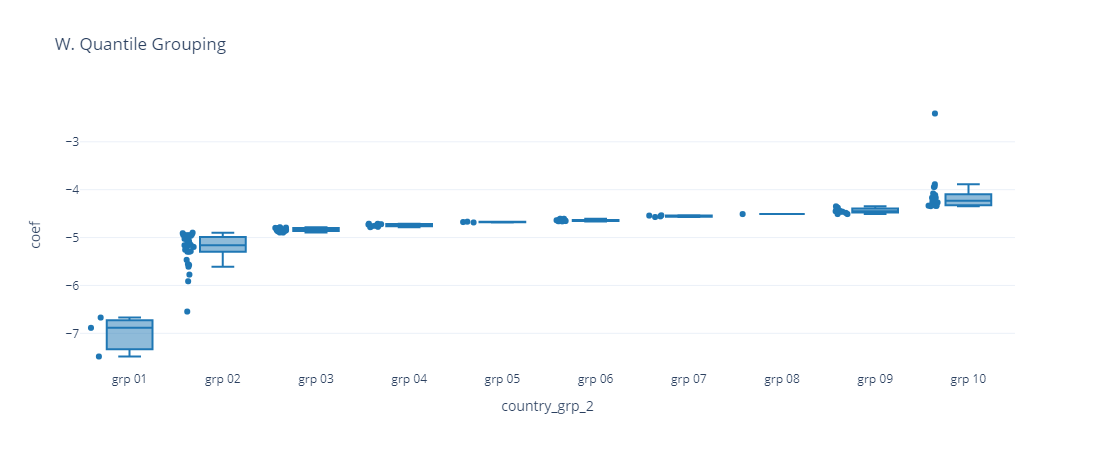

In [49]:
dta=dm_di.loc[(dm_di['factors']=='country_grp')].sort_values('country_grp_2')
fig = px.box(dta, x="country_grp_2", y="coef", points="all",template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title='W. Quantile Grouping')
fig.show()

In [50]:
# so roughly equal weight split except for the last group where decided to group last two decile together
# Again, this apprach is not "bullet proof"
dm_di.loc[(dm_di['factors']=='country_grp')].groupby('country_grp_2')['factor_weight'].sum()

country_grp_2
grp 01    0.077305
grp 02    0.097479
grp 03    0.089142
grp 04    0.098558
grp 05    0.098559
grp 06    0.120789
grp 07    0.050683
grp 08    0.096880
grp 09    0.153776
grp 10    0.116829
Name: factor_weight, dtype: float64

In [51]:
country_group_list=np.sort(dm_di.loc[(dm_di['factors']=='country_grp'),'country_grp_2'].unique()).tolist()

dd_country_group=widgets.Dropdown(options=country_group_list)
output_country_group=widgets.Output()

def dd_country_group_eventhandler(change):
    output_country_group.clear_output()
    with output_country_group:
        display(dm_di.loc[(dm_di['factors']=='country_grp') & (dm_di['country_grp_2']==change.new)])

dd_country_group.observe(dd_country_group_eventhandler, names='value')
display(dd_country_group)

Dropdown(options=('grp 01', 'grp 02', 'grp 03', 'grp 04', 'grp 05', 'grp 06', 'grp 07', 'grp 08', 'grp 09', 'g…

In [52]:
display(output_country_group)

Output()

In [53]:
# inserting the new country groups into the main data frame
mapping_2=pd.Series(dm_di.loc[dm_di['factors']=='country_grp','country_grp_2'].to_numpy(), index=dm_di.loc[dm_di['factors']=='country_grp','levels'])
dff['country_grp_2']=dff['country_grp'].map(mapping_2)

In [54]:
dm_2=dmatrix('-1+country_grp_2 + country_grp_2:standardize(time_1) + tail_grp:standardize(time_2)',dff, return_type='dataframe')

In [55]:
# Repeat of the previous step to capture additional info re the model factors and levels
di_2=dm_2.design_info

# column_names are all encoded factors / terms 
dm_di_2=pd.DataFrame({'col_name':di_2.column_names})

# for each factor / terms, we encode the corresponding factors
factors=[None]*len(di_2.column_names)
for elt in di_2.term_names:
    slice_=di_2.term_name_slices[elt]
    factors[slice_]=[elt]*len(factors[slice_])

dm_di_2['factors']=factors

#We also capture the corresponding term levels
#getting pretty factor levels, experimental
# useful for "pretty" plotting factor model parameters

dm_di_2['levels']=dm_di_2['col_name'].str.findall(r'\((.*)\)|\[(.*)\]')
dm_di_2['levels']=dm_di_2['levels'].apply(lambda x: str(x))
pattern = '|'.join(['\[', '\]', '\(','\)',"'",'T\.',','])
dm_di_2['levels']=dm_di_2['levels'].str.replace(pattern, '').str.strip()

In [56]:
dm_di_2

col_name  \
0                       country_grp_2[grp 01]   
1                       country_grp_2[grp 02]   
2                       country_grp_2[grp 03]   
3                       country_grp_2[grp 04]   
4                       country_grp_2[grp 05]   
5                       country_grp_2[grp 06]   
6                       country_grp_2[grp 07]   
7                       country_grp_2[grp 08]   
8                       country_grp_2[grp 09]   
9                       country_grp_2[grp 10]   
10  country_grp_2[grp 01]:standardize(time_1)   
11  country_grp_2[grp 02]:standardize(time_1)   
12  country_grp_2[grp 03]:standardize(time_1)   
13  country_grp_2[grp 04]:standardize(time_1)   
14  country_grp_2[grp 05]:standardize(time_1)   
15  country_grp_2[grp 06]:standardize(time_1)   
16  country_grp_2[grp 07]:standardize(time_1)   
17  country_grp_2[grp 08]:standardize(time_1)   
18  country_grp_2[grp 09]:standardize(time_1)   
19  country_grp_2[grp 10]:standardize(time_1)   
20  tail_grp[tail grp 01]:standardize(time_2)   
21  tail_grp[tail grp 02]:standardize(time_2)   

                              factors              levels  
0                       country_grp_2              grp 01  
1                       country_grp_2              grp 02  
2                       country_grp_2              grp 03  
3                       country_grp_2              grp 04  
4                       country_grp_2              grp 05  
5                       country_grp_2              grp 06  
6                       country_grp_2              grp 07  
7                       country_grp_2              grp 08  
8                       country_grp_2              grp 09  
9                       country_grp_2              grp 10  
10  country_grp_2:standardize(time_1)       grp 01 time_1  
11  country_grp_2:standardize(time_1)       grp 02 time_1  
12  country_grp_2:standardize(time_1)       grp 03 time_1  
13  country_grp_2:standardize(time_1)       grp 04 time_1  
14  country_grp_2:standardize(time_1)       grp 05 time_1  
15  country_grp_2:standardize(time_1)       grp 06 time_1  
16  country_grp_2:standardize(time_1)       grp 07 time_1  
17  country_grp_2:standardize(time_1)       grp 08 time_1  
18  country_grp_2:standardize(time_1)       grp 09 time_1  
19  country_grp_2:standardize(time_1)       grp 10 time_1  
20       tail_grp:standardize(time_2)  tail grp 01 time_2  
21       tail_grp:standardize(time_2)  tail grp 02 time_2

In [57]:
# Building the second design matrix of observations only
X_2=dm_2.loc[(dff['data']=='Observed') & (dff['devt_time']>0) & (dff['link_ratio']>1)]
y=(dff[(dff['data']=='Observed') & (dff['devt_time']>0)& (dff['link_ratio']>1)]['link_ratio']-1) #target variable
wgt=dff[(dff['data']=='Observed') & (dff['devt_time']>0)& (dff['link_ratio']>1)]['weight'] # weight vector

In [58]:
#fitted the second model
tt = TransformedTargetRegressor(regressor=LinearRegression(fit_intercept=False),func=np.log, inverse_func=np.exp)
tt.fit(X_2, y, wgt)

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log'>,
              inverse_func=<ufunc 'exp'>,
              regressor=LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False),
              transformer=None)

In [59]:
dm_di_2['coef']=tt.regressor_.coef_
dm_di_2.head()

col_name        factors  levels      coef
0  country_grp_2[grp 01]  country_grp_2  grp 01 -7.659119
1  country_grp_2[grp 02]  country_grp_2  grp 02 -5.160593
2  country_grp_2[grp 03]  country_grp_2  grp 03 -4.764284
3  country_grp_2[grp 04]  country_grp_2  grp 04 -4.683239
4  country_grp_2[grp 05]  country_grp_2  grp 05 -4.619165

In [60]:
pred_2=dff.loc[(dff['data']=='Observed') & (dff['devt_time']>0) & (dff['link_ratio']>1),['country_area','country_grp_2','devt_time','weight','link_ratio']]
pred_2['y']=np.log(pred_2['link_ratio']-1)
pred_2['y_hat'] = np.log(tt.predict(X_2))
pred_2['residuals']=pred_2['y']-pred_2['y_hat']

In [61]:
residuals=pred_2['residuals'].to_numpy()
W=np.diag(pred_2['weight'].to_numpy())
residuals=residuals[np.newaxis]
w_rss = residuals @ W @ residuals.T
w_sigma_squared_hat = w_rss[0, 0] / (X_2.shape[0] - X_2.shape[1])
w_var_beta_hat = np.linalg.inv(X_2.to_numpy().T @ W @ X_2.to_numpy()) * w_sigma_squared_hat
w_stderr_2=np.sqrt(np.diag(w_var_beta_hat))

In [62]:
y_m=pred_2['y'].T@pred_2['weight']/pred_2['weight'].sum()
ss_tot=(pred_2['y']-y_m)@ np.diag(pred_2['weight'])  @ (pred_2['y']-y_m).T
ss_res=(pred_2['residuals'] @ np.diag(pred_2['weight']) @ pred_2['residuals'].T)

r2=1-ss_res/ss_tot
r2_adj=1-(ss_res/ss_tot)*((X_2.shape[0]-1)/(X_2.shape[0]-X_2.shape[1]-1))
r2_adj

0.7253412507806919

In [63]:
dm_di_2['w_stderr']=w_stderr_2
dm_di_2['ci_95_upper']=tt.regressor_.coef_+w_stderr_2*tval
dm_di_2['ci_95_lower']=tt.regressor_.coef_-w_stderr_2*tval
dm_di_2

col_name  \
0                       country_grp_2[grp 01]   
1                       country_grp_2[grp 02]   
2                       country_grp_2[grp 03]   
3                       country_grp_2[grp 04]   
4                       country_grp_2[grp 05]   
5                       country_grp_2[grp 06]   
6                       country_grp_2[grp 07]   
7                       country_grp_2[grp 08]   
8                       country_grp_2[grp 09]   
9                       country_grp_2[grp 10]   
10  country_grp_2[grp 01]:standardize(time_1)   
11  country_grp_2[grp 02]:standardize(time_1)   
12  country_grp_2[grp 03]:standardize(time_1)   
13  country_grp_2[grp 04]:standardize(time_1)   
14  country_grp_2[grp 05]:standardize(time_1)   
15  country_grp_2[grp 06]:standardize(time_1)   
16  country_grp_2[grp 07]:standardize(time_1)   
17  country_grp_2[grp 08]:standardize(time_1)   
18  country_grp_2[grp 09]:standardize(time_1)   
19  country_grp_2[grp 10]:standardize(time_1)   
20  tail_grp[tail grp 01]:standardize(time_2)   
21  tail_grp[tail grp 02]:standardize(time_2)   

                              factors              levels      coef  w_stderr  \
0                       country_grp_2              grp 01 -7.659119  0.053505   
1                       country_grp_2              grp 02 -5.160593  0.045126   
2                       country_grp_2              grp 03 -4.764284  0.046003   
3                       country_grp_2              grp 04 -4.683239  0.044501   
4                       country_grp_2              grp 05 -4.619165  0.043446   
5                       country_grp_2              grp 06 -4.614515  0.042287   
6                       country_grp_2              grp 07 -4.464787  0.053334   
7                       country_grp_2              grp 08 -4.430692  0.049471   
8                       country_grp_2              grp 09 -4.359521  0.039576   
9                       country_grp_2              grp 10 -4.173539  0.043414   
10  country_grp_2:standardize(time_1)       grp 01 time_1 -1.128267  0.046266   
11  country_grp_2:standardize(time_1)       grp 02 time_1 -0.492580  0.028393   
12  country_grp_2:standardize(time_1)       grp 03 time_1 -0.590054  0.040138   
13  country_grp_2:standardize(time_1)       grp 04 time_1 -0.732364  0.047639   
14  country_grp_2:standardize(time_1)       grp 05 time_1 -0.479530  0.050480   
15  country_grp_2:standardize(time_1)       grp 06 time_1 -0.611461  0.041801   
16  country_grp_2:standardize(time_1)       grp 07 time_1 -0.586976  0.063522   
17  country_grp_2:standardize(time_1)       grp 08 time_1 -1.015200  0.066267   
18  country_grp_2:standardize(time_1)       grp 09 time_1 -0.417837  0.045052   
19  country_grp_2:standardize(time_1)       grp 10 time_1 -0.276365  0.043400   
20       tail_grp:standardize(time_2)  tail grp 01 time_2 -3.077951  0.069772   
21       tail_grp:standardize(time_2)  tail grp 02 time_2 -1.915266  0.040145   

    ci_95_upper  ci_95_lower  
0     -7.554235    -7.764003  
1     -5.072135    -5.249051  
2     -4.674106    -4.854462  
3     -4.596004    -4.770473  
4     -4.533998    -4.704332  
5     -4.531620    -4.697410  
6     -4.360238    -4.569335  
7     -4.333715    -4.527669  
8     -4.281941    -4.437100  
9     -4.088436    -4.258642  
10    -1.037573    -1.218960  
11    -0.436923    -0.548238  
12    -0.511374    -0.668735  
13    -0.638977    -0.825750  
14    -0.380575    -0.578486  
15    -0.529519    -0.693402  
16    -0.462457    -0.711496  
17    -0.885300    -1.145101  
18    -0.329522    -0.506151  
19    -0.191290    -0.361441  
20    -2.941179    -3.214723  
21    -1.836571    -1.993962

In [64]:
mod_wls = sm.WLS(np.log(y), X_2, weights=wgt)
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:             link_ratio   R-squared:                       0.726
Model:                            WLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     994.8
Date:                Fri, 24 Apr 2020   Prob (F-statistic):               0.00
Time:                        09:08:28   Log-Likelihood:                -17384.
No. Observations:                7902   AIC:                         3.481e+04
Df Residuals:                    7880   BIC:                         3.497e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [65]:
factors_list=dm_di_2['factors'].unique().tolist()
dd_factors=widgets.Dropdown(options=factors_list)
output_factors=widgets.Output()

def dd_factors_eventhandler(change):
    output_factors.clear_output()
    plot_data=dm_di_2.loc[(dm_di_2['factors']==change.new)].sort_values('levels') #.copy(deep=True).sort_values(by='coef')
    fig=px.line(plot_data,x='levels',y='coef',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.add_scatter(x=plot_data['levels'],y=plot_data['ci_95_upper'],line_dash='dash', mode='lines',name='95% CI Upper Bound', marker_color=px.colors.qualitative.D3[1])
    fig.add_scatter(x=plot_data['levels'],y=plot_data['ci_95_lower'],line_dash='dash', mode='lines', name='95% CI Lower Bound', marker_color=px.colors.qualitative.D3[1])
    fig.update_layout(xaxis_title='Levels', yaxis_title='Weighted Linear Model Parameters')
    with output_factors:
        display(fig)

dd_factors.observe(dd_factors_eventhandler, names='value')
display(dd_factors)

Dropdown(options=('country_grp_2', 'country_grp_2:standardize(time_1)', 'tail_grp:standardize(time_2)'), value…

In [66]:
display(output_factors)

Output()

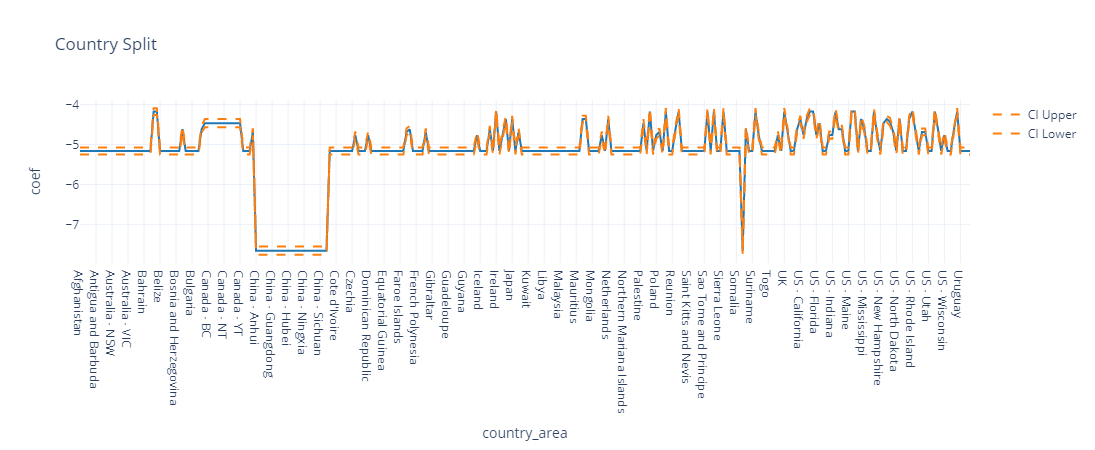

In [67]:
# quick overview of country model parameters by country area instead
a=dff.groupby(by=['country_area'])['country_grp_2'].max().reset_index()
a=a.merge(dm_di_2, how='left',left_on='country_grp_2',right_on='levels')
fig=px.line(a,x='country_area',y='coef',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title='Country Split')
fig.add_scatter(x=a['country_area'],y=a['ci_95_upper'],line_dash='dash', name='CI Upper',marker_color=px.colors.qualitative.D3[1])
fig.add_scatter(x=a['country_area'],y=a['ci_95_lower'],line_dash='dash', name='CI Lower', marker_color=px.colors.qualitative.D3[1])
fig.show()

In [68]:
dff['link_ratio_predicted_2']=1+tt.predict(dm_2)

In [69]:
country_list_3=dff['country_area'].unique().tolist()
dd_country_3=widgets.Dropdown(options=country_list_3)
output_country_3=widgets.Output()

def dd_country_3_eventhandler(change):
    output_country_3.clear_output()
    plot_data=dff.loc[(dff['country_area']==change.new) & (dff['devt_time']>0)]
    fig=px.line(plot_data,x='devt_time',y='link_ratio',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.add_scatter(x=plot_data['devt_time'],y=plot_data['link_ratio_predicted_2'],line_dash='dash', marker_color=px.colors.qualitative.D3[1])  
    fig.update_layout(yaxis_title='Link Ratio / Daily Development Factor ', showlegend=False)
    with output_country_3:
        display(fig)

dd_country_3.observe(dd_country_3_eventhandler, names='value')
display(dd_country_3)

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentin…

In [70]:
display(output_country_3)

Output()

#### Investigate the Model Residuals

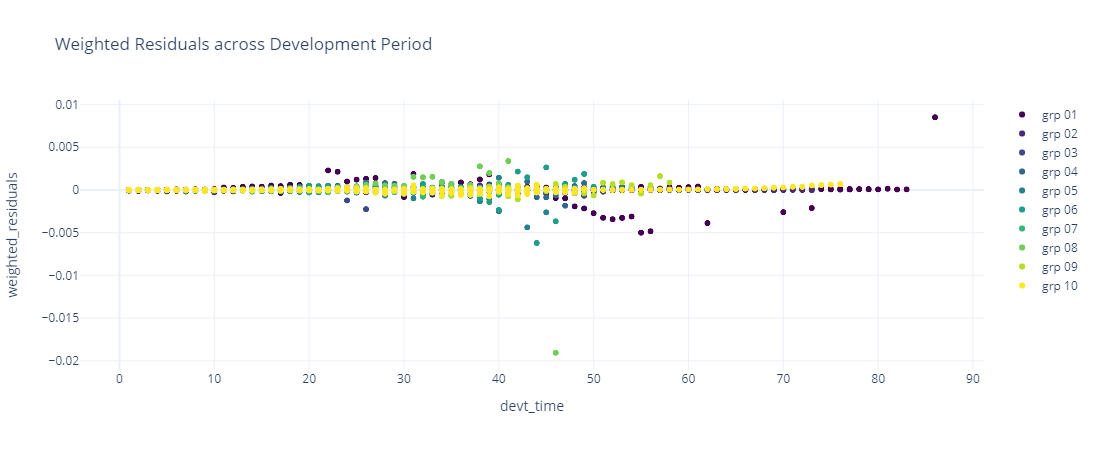

In [71]:
pred_2['weigt_perc']=pred_2['weight']/pred_2['weight'].sum()
pred_2['weighted_residuals']=pred_2['residuals']*pred_2['weigt_perc']
pred_2.sort_values('country_grp_2', inplace=True)
fig=px.scatter(pred_2,x='devt_time',y='weighted_residuals', hover_name='country_area', hover_data=['y','y_hat'], template='plotly_white',
               color='country_grp_2', color_discrete_sequence=px.colors.sequential.Viridis, title='Weighted Residuals across Development Period')
fig.show()

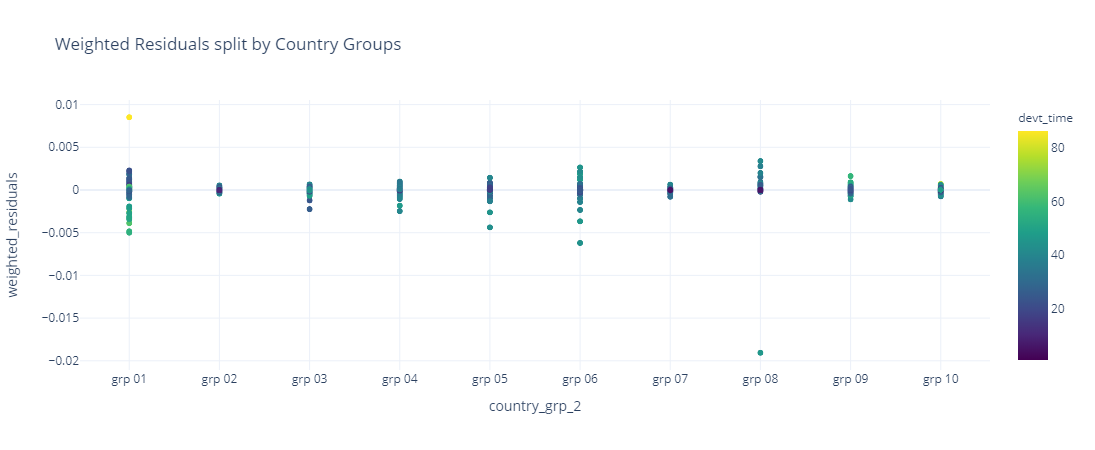

In [72]:
fig=px.scatter(pred_2,x='country_grp_2',y='weighted_residuals', hover_name='country_area', hover_data=['y','y_hat'], template='plotly_white',
               color='devt_time', color_continuous_scale=px.colors.sequential.Viridis, title='Weighted Residuals split by Country Groups')
fig.show()

Outlier Residuals driven by China. Not real impact on projections as China numbers are fully developed based on reported numbers.
Maybe even worth not including some countries like China, South Korea in the projection model.
Though as per the model definition, it should not impact the projection model for the other countries (own group group 01 and own tail factor as well)

#### Selected Model Results & Projections

In [73]:
# same code as before to calculate the estimate number of confirmed cases up until july 1st

dff['lr_cumul_2']=dff.loc[dff['data']=='Estimate'].groupby(['country_area'])['link_ratio_predicted_2'].cumprod()
dff['pred_cases_2']=dff['lr_cumul_2']*dff.groupby(['country_area'])['confirmed_cases'].transform('max')
dff['all_cases_2']=dff['confirmed_cases'].fillna(0)+dff['pred_cases_2'].fillna(0)
dff['all_cases_inc_2']=dff.groupby(['country_area'])['all_cases_2'].diff()
dff.loc[dff['all_cases_inc_2'].isnull(),'all_cases_inc_2']=dff.loc[dff['all_cases_inc_2'].isnull(),'all_cases_2']

In [74]:
country_list_2=dff['country'].unique().tolist()
dd_country_2=widgets.Dropdown(options=country_list_2)
output_country_2=widgets.Output()

def dd_country_2_eventhandler(change):
    output_country_2.clear_output()
    plot_data=dff.loc[dff['country']==change.new].groupby(['date','data']).sum().reset_index()
    fig=px.bar(plot_data,x='date',y='all_cases_inc_2', color='data',
              template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig.update_layout(yaxis_title='Daily New Confirmed Cases')
    fig2=px.bar(plot_data,x='date',y='all_cases_2', color='data',
              template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title=change.new)
    fig2.update_layout(yaxis_title='Cumulative Confirmed Cases')
    with output_country_2:
        display(fig)
        display(fig2)

dd_country_2.observe(dd_country_2_eventhandler, names='value')
display(dd_country_2)

Dropdown(options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Anguilla', 'Antigua and Barbuda', 'Argentin…

In [75]:
display(output_country_2)

Output()

#### Aggregated Projections

Though __not including__ a number of countries (see early data prep section) that have not reached the 5 per mio per capita rate

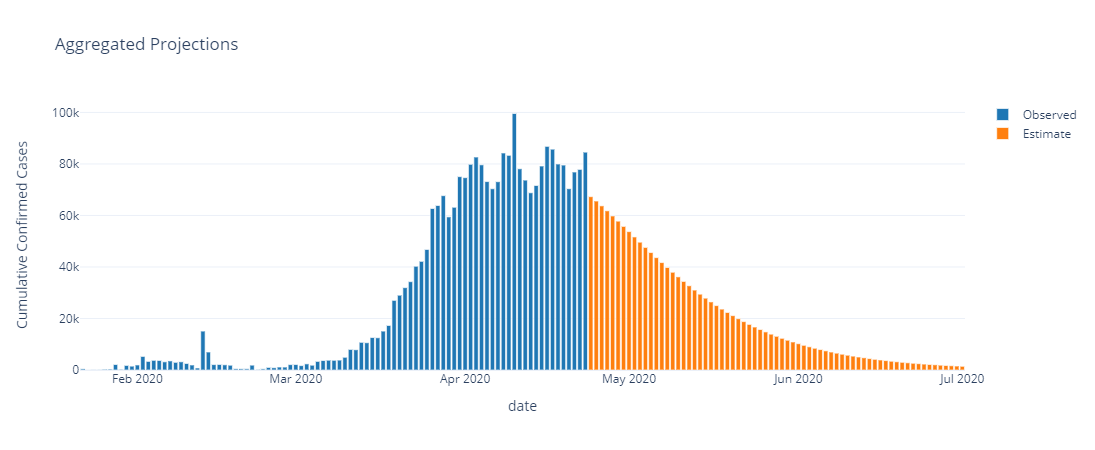

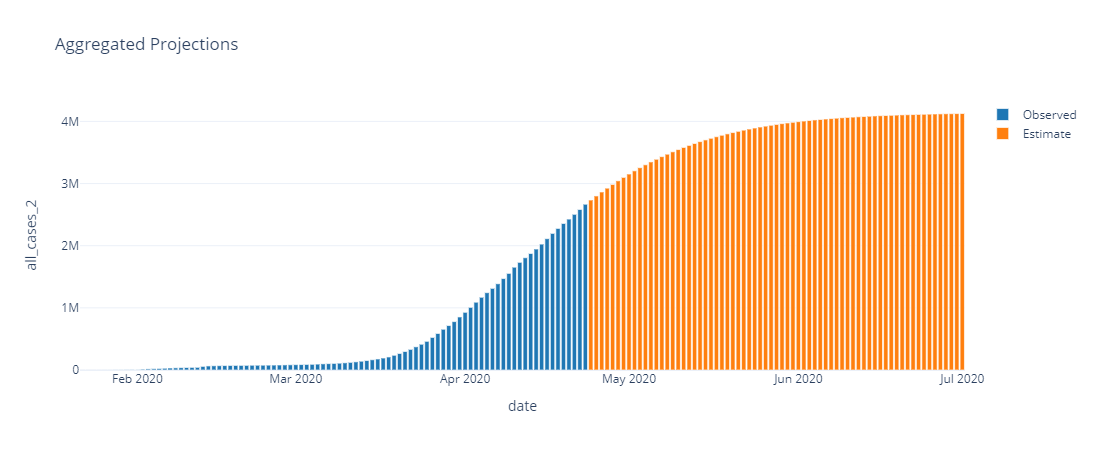

In [76]:
# Total daily projections, though not including a number of countries (see early data prep section) that have not reached the 5 per mio per capita rate
plot_data=dff.groupby(['date','data']).sum().reset_index()
fig=px.bar(plot_data,x='date',y='all_cases_inc_2', color='data',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title='Aggregated Projections')
fig.update_layout(yaxis_title='Daily New Confirmed Cases')

fig2=px.bar(plot_data,x='date',y='all_cases_2', color='data',template='plotly_white',color_discrete_sequence=px.colors.qualitative.D3, title='Aggregated Projections')
fig.update_layout(yaxis_title='Cumulative Confirmed Cases')
fig.show()
fig2.show()

### Seeing Results in the Plotly Dash App

Go to the Projection Section on the online app: [COVID-19 Dash App](https://covid19-curves.herokuapp.com/)
